# Monter Carlo test for the Kolmogorov-Smirnov test in Julia

Piotr Nowicki  
2024-11-14

The Kolmogorv-Smirnov (KS) test, along with other goodness-of-fit tests,
assumes that the parameters of a distribution are provided a priori.
However, these parameters are often estimated in practice. When
parameters are estimated, the calculated p-values from the KS test may
be innacurate. To obtain correct p-values, we can conduct a Monte Carlo
test. This involves drawing samples from an assumed distribution and
obtaining the distribution of the KS statistic or p-value under
parameter estimation. This work provides an example of using the Monte
Carlo test to correct the KS test.

In [1]:
using Distributions, HypothesisTests, Plots, Random

Random.seed!(2024)

# Number of simulations
N = 100000;

Prepare data

In [2]:
# Suppose data come from N(5, 2) when the null hypothesis is true
norm_sims = rand(Normal(5, 2), (N, 30));

# Suppose data come from a gamma distribution when the alternative hypothesis is true
gamma_sims = rand(Gamma(9, 1/2), (N, 30));

P-value distributions when parameters are known

In [3]:
# P-value distribution when the null hypothesis is true
pvals_true = map(row -> pvalue(ExactOneSampleKSTest(row, Normal(5, 2))), eachrow(norm_sims));

# How many p-values are below the threshold?
err_true_rate = mean(pvals_true .< 0.05);

# P-value distribution when the null hypothesis is false
pvals_false = map(row -> pvalue(ExactOneSampleKSTest(row, Normal(5, 2))), eachrow(gamma_sims));

# How many p-values are below the threshold?
err_false_rate = mean(pvals_false .< 0.05);

Uncorrected p-value distributions when parameters are unknown

In [4]:
# P-value distribution when the family is true
pvals_true_uncorrected = map(row -> pvalue(ExactOneSampleKSTest(row, Normal(mean(row), std(row)))), eachrow(norm_sims));

# How many p-values are below the threshold?
err_true_rate_uncorrected = mean(pvals_true_uncorrected .< 0.05);

# P-value distribution when the family is false
pvals_false_uncorrected = map(row -> pvalue(ExactOneSampleKSTest(row, Normal(mean(row), std(row)))), eachrow(gamma_sims));

# How many p-values are below the threshold?
err_false_rate_uncorrected = mean(pvals_false_uncorrected .< 0.05);

Corrected p-value distributions when parameters are unknown

In [5]:
# Simulate data from a referenced distribution and calculate p-values
ref_sims = rand(Normal(0, 1), (N, 30));
pval_distr = map(row -> pvalue(ExactOneSampleKSTest(row, Normal(mean(row), std(row)))), eachrow(ref_sims));

# Calculate p-value for your data and compare to the obtained p-value distribution above
pvals_true_corrected = mean(pval_distr .< pvals_true_uncorrected', dims=2)

# How many p-values are below the threshold?
err_true_rate_corrected = mean(pvals_true_corrected .< 0.05);

# Repeat as above but suppose your data come from the gamma distribution
pvals_false_corrected = mean(pval_distr .< pvals_false_uncorrected', dims=2);

# How many p-values are below the threshold?
err_false_rate_corrected = mean(pvals_false_corrected .< 0.05);

Visualisation of the p-value distributions

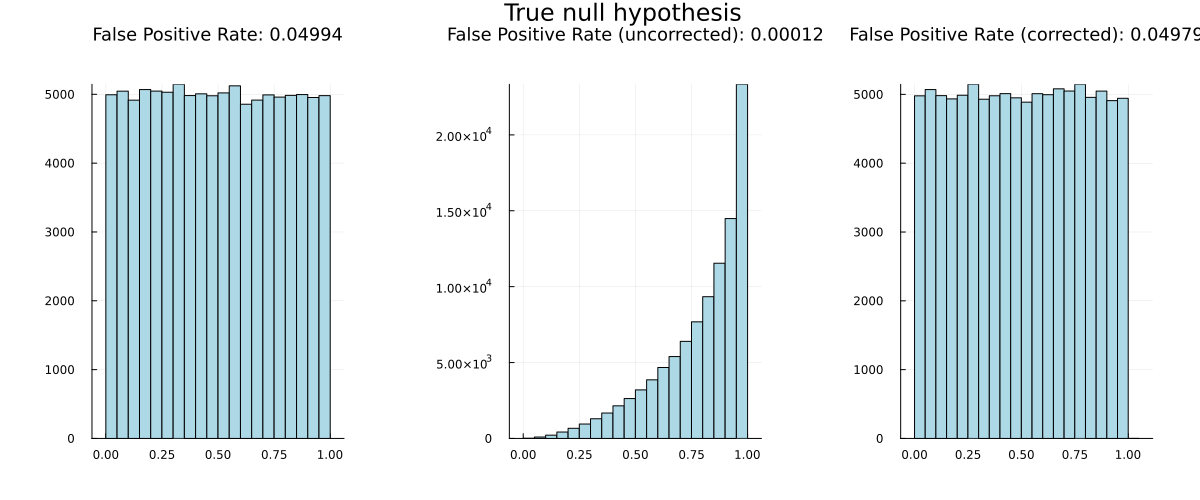

In [6]:
layout = @layout [a b c]

p = plot(legend=false, layout=layout, size=(1200, 500), margin=10Plots.mm, topmargin=10Plots.mm, suptitle="True null hypothesis")

histogram!(p[1], pvals_true, bins=30, color=:lightblue, title="False Positive Rate: $err_true_rate", titlefont=12)
histogram!(p[2], pvals_true_uncorrected, bins=30, color=:lightblue, title="False Positive Rate (uncorrected): $err_true_rate_uncorrected", titlefont=12)
histogram!(p[3], pvals_true_corrected, bins=30, color=:lightblue, title="False Positive Rate (corrected): $err_true_rate_corrected", titlefont=12)

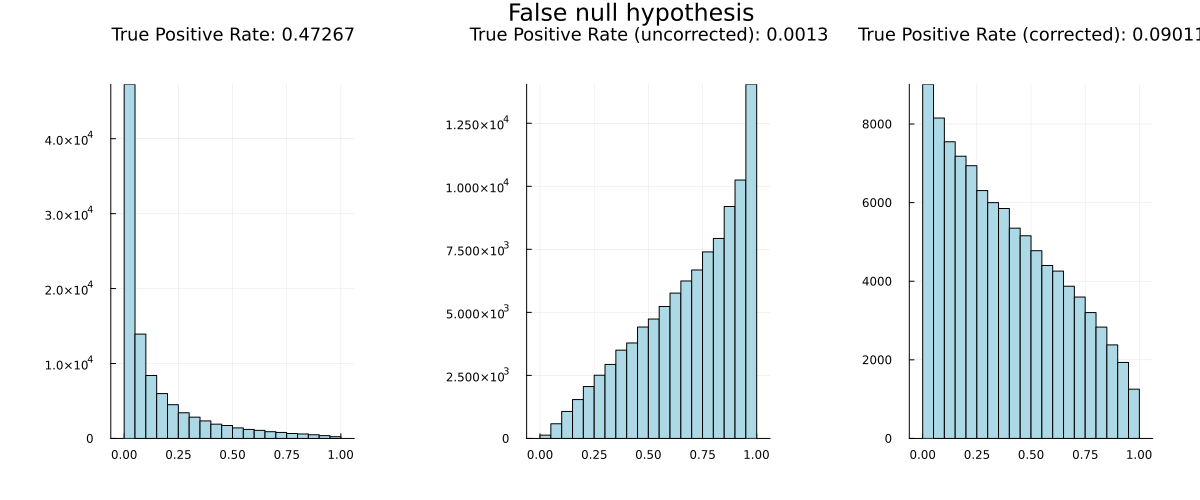

In [7]:
layout = @layout [a b c]

p = plot(legend=false, layout=layout, size=(1200, 500), margin=10Plots.mm, topmargin=10Plots.mm, suptitle="False null hypothesis")

histogram!(p[1], pvals_false, bins=30, color=:lightblue, title="True Positive Rate: $err_false_rate", titlefont=12)
histogram!(p[2], pvals_false_uncorrected, bins=30, color=:lightblue, title="True Positive Rate (uncorrected): $err_false_rate_uncorrected", titlefont=12)
histogram!(p[3], pvals_false_corrected, bins=30, color=:lightblue, title="True Positive Rate (corrected): $err_false_rate_corrected", titlefont=12)